# Data Cleaning

Data is anonymized by Birkbeck personnel using the 'Student Data Anonymization' script and sent outside the university for further processing using this script.

In [1]:
##########################################

# Start here once given anonymized csvs.

###########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import LLB_custom_scripts_mac
from LLB_custom_scripts_mac \
 import make_students_dataframe, make_attempts_dataframe, \
        add_fr_and_dr_flags, make_module_summary, \
        create_outcomes_series, plot_single_cohort_progression, \
        plot_all_yrs_progression, get_prop_failures_yr_1_due_to_NS, \
        get_prob_pass_FYC_if_submit
import csv
from collections import Counter
import re
from functools import reduce
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

### Storing each anonymized dataframe of student grades in a dictionary

In [2]:
# Loop through anonymized files and save the dataframes 
# in a dictionary.
# Also make a dictionary with the number of assessments in 
# each module, each year.
# Store the 201011 student numbers for comparison

anon_module_csv_path = ("/Users/Kate/Desktop/Vicky project/"
                        "Data/anonymized module csvs/")

module_files = {}
n_assessments_module_dict = {}
students_pre2013 = []

for filename in os.listdir(anon_module_csv_path):
    if filename == '.DS_Store': 
        continue
    else:  
        year, module, tmp = f'{filename}'.split('.')[0].split('_')                                       
        if year in ['200910', '201011', '201112', '201213']:
            df = pd.read_csv(
                        anon_module_csv_path + f'{filename}')
            students_pre2013.extend(df['SPR Code'].tolist())
        else: 
            module_name = f'{filename}'.split('.')[0]
            module_files[module_name] = pd.read_csv(
                                    anon_module_csv_path + f'{filename}')
            module_files[module_name].set_index('SPR Code', inplace=True)
            num_assessments = (module_files[module_name]
                               .columns[-1].split(' ')[1])
            n_assessments_module_dict[module_name] = num_assessments
            
students_pre2013 = list(set(students_pre2013))

### Removing all students not in LLB program or with blank or ambiguous results

In [3]:
# Remove all students with blank results
for dfname, df in module_files.items():
    module_files[dfname] = df[df['Result'].notnull()]

In [4]:
# Remove all students not in the LLB programme
for dfname, df in module_files.items():
    module_files[dfname] = df[df['Programme'].str.startswith('LLB Law')] 

In [5]:
# Remove all duplicated student entries from module dataframes 
# since confusion about a variable, will have to remove all that were 
# duplicated
for dfname, df in module_files.items():
    module_files[dfname] = df[~df.index.duplicated(keep=False)]

In [6]:
# Change assessment marks to floating point
for dfname, df in module_files.items():
    n_assessments = int(n_assessments_module_dict[dfname])
    module_files[dfname]['Assessment 1 Mark'] = df['Assessment 1 Mark'].astype('float')
    if n_assessments == 2:
        module_files[dfname]['Assessment 2 Mark'] = df['Assessment 2 Mark'].astype('float')

### Clean module files

In [7]:
# Create Attempt type column and Attempt diff column.
# Attempt diff is difference between module attempt number
# and assignment attempt numbers. 
# Attempt diff will be used for reassessment calculations.
for dfname, df in module_files.items():
    # Calculate how many attempts were in the current year.
    #    Once you have the attempt diff, you can figure out which attempt the numbers 
    #    for the module results, etc pertain to.
    n_assessments = int(n_assessments_module_dict[dfname])
    if n_assessments == 1:
        df['Attempt diff'] = df['Attempt'].astype('float') \
                                - df['Assessment 1 Attempt'].astype('float')
    elif n_assessments == 2:
        for index, row in df.iterrows():
            if float(row['Assessment 1 Attempt']) > float(row['Assessment 2 Attempt']):
                df.at[index, 'Attempt diff'] = float(row['Attempt']) \
                                                - float(row['Assessment 1 Attempt'])
            else:
                df.at[index, 'Attempt diff'] = float(row['Attempt']) \
                                                - float(row['Assessment 2 Attempt'])
    else:
        print('error', dfname)
    # Add new column for Attempt Type
    df['Attempt type'] = 'Assessment'

In [8]:
# Make pass/fail flag for each individual assessment.
# Assigns 'P' to 'P' or 'LP'
# Assigns 'F' to 'F', 'W', 'FR', 'DR', or 'LF'
# Identifies nan grades to be dealt with
for dfname, df in module_files.items():
    year, module, tmp = dfname.split('_')
    # Make a df to store assessment results
    num_assessments = int(n_assessments_module_dict[dfname])
    df_column_names = [f'Assessment {a} P or F' \
                       for a in range(1, num_assessments + 1)]
    df_idx = module_files[dfname].index
    P_F_status = pd.DataFrame(data=[], index=df_idx, \
                                 columns = df_column_names)

    # Populate df
    for index, row in module_files[dfname].iterrows():
        for a in range(1,num_assessments+1):
            grade = row[f'Assessment {str(a)} Grade']
            if grade in ['P','LP']:
                P_F_status.at[index, f'Assessment {str(a)} P or F'] = 'P'
            elif grade in ['F', 'W', 'FR', 'DR', 'LF', 'NS']:
                P_F_status.at[index, f'Assessment {str(a)} P or F'] = 'F'
            else:
                P_F_status.at[index, f'Assessment {str(a)} P or F'] = np.NaN
                print(module, year, index, 'has nan grade because', 
                      f'Assessment {str(a)} Grade was', row[f'Assessment {str(a)} Grade'], 
                      f'Assessment {str(a)} Mark was', row[f'Assessment {str(a)} Mark'],
                      'Module Result was', row['Result'])
    # checking on these grade designations
    module_files[dfname] = df.join(P_F_status, how='left')

In [9]:
# Get name of next year's module and determine 
# whether student retook the module as well as
# students' repeat/pass status the following year.
# Create columns pertaining to retakes.

def make_retake_columns(row, module_files, n_assessments_module_dict,
                        next_year_name, retake_type='main'):
    '''Takes in a row from a df, and returns a value to put in two
        new columns in the same df.
       'Retake next year', and 'Retake and pass'.
       retake_type can be 'main' or 'pass'
    '''
    SPR_code = row.name
    if next_year_name != None:
        # If SPR_code in next year's module...
        if index in module_files[next_year_name].index.values: 
            retake_attempt_num = float(module_files[next_year_name].at[index, 'Attempt'])
            current_attempt_num = float(row['Attempt'])
            diff_in_attempts = retake_attempt_num - current_attempt_num            
            retake_next_year = f'Y, Attempt no. diff = {diff_in_attempts}'
            module_files[next_year_name].at[index, 'Attempt type'] = 'Retake'
            if row['Result'] == 'D':
                module_files[next_year_name].at[index, 'Attempt type'] = 'DR Retake'    
            n_assessments_next_year = n_assessments_module_dict[next_year_name]
            if 'Assessment 1 Mark' in row.index:          
                if float(n_assessments_next_year) == 1.0:
                    if float(module_files[next_year_name]
                             .at[index, 'Assessment 1 Mark']) >= 40.0:
                        retake_and_pass = True
                    else:
                        retake_and_pass = False
                elif float(n_assessments_next_year) == 2.0: 
                    # if 2 assignments the following year
                    if ((0.5 * float(module_files[next_year_name]
                                     .at[index, 'Assessment 1 Mark'])) 
                         + (0.5 * float(module_files[next_year_name]
                                        .at[index, 'Assessment 2 Mark']))) >= 40.0:
                        retake_and_pass = True
                    else: 
                        retake_and_pass = False
            else:
                if ((module_files[next_year_name].at[index, 'Assessment 1 P or F'] == 'P')
                    & (module_files[next_year_name].at[index, 'Assessment 2 P or F'] == 'P')):
                    retake_and_pass = True
                elif module_files[next_year_name].at[index, 'Result'] == 'P':
                    retake_and_pass = True
                else:
                    retake_and_pass = False
        else: # index not in next year's module
            retake_next_year = 'N'
            retake_and_pass = np.NaN
    else: # year is '201718'
        retake_next_year = 'unknown'
        retake_and_pass = np.NaN
        if current_year != '201718':
            print(f'error parsing year') # no errors
    if retake_type=='main':
        return retake_next_year
    elif retake_type=='pass':
        return retake_and_pass
    
###################################################
####### run make_retake_columns() function ########
##### add FR retake flag and DR retake flag #######
###################################################
for dfname, df in module_files.items():
    current_year = dfname.split('_')[0]
    module = dfname.split('_')[1]
    # Create FR and DR flags
    df = add_fr_and_dr_flags(df) 
    # Determine next year's module file name
    if current_year == '201718':
        next_year_name = None
    else:
        next_year_name = dfname.split('_')[0][:2] + \
            str(int(dfname.split('_')[0][2:4]) + 1) + \
            str(int(dfname.split('_')[0][4:]) + 1) + '_' + \
            dfname.split('_')[1] + '_' + dfname.split('_')[2] 
    # Create retake columns with empty lists
#     df['Retake next year'] = pd.Series(dtype=object)
#     df['Retake and pass'] = pd.Series(dtype=object)
    df['Retake next year'] = df.apply(lambda row: 
                             make_retake_columns(row, module_files, 
                                                 next_year_name, 
                                                 retake_type='main'), 
                             axis=1, result_type='expand')
    df['Retake and pass'] = df.apply(lambda row: 
                             make_retake_columns(row, module_files, 
                                                 next_year_name, 
                                                 retake_type='pass'), 
                             axis=1)
    if not sum(df['Retake next year'].isin(['N', 'unknown'])) > 0:
        print(dfname, df['Retake next year'])

201415_CONTRACT_assessment SPR Code
1d60fe17-6a8e-4fb3-bd0e-1fb0e918a397    Y, Attempt no. diff = 2.0
597b158a-d5ed-4c1a-aacf-c3d57a9d550f    Y, Attempt no. diff = 2.0
5e3de25b-86d3-48e3-9a32-cdc6ace2abbf    Y, Attempt no. diff = 0.0
1bc2a73b-4f94-4ae1-8b14-60c632eb5d39    Y, Attempt no. diff = 2.0
fcc94f9b-9584-4d46-8f4c-d77113cd73b9    Y, Attempt no. diff = 0.0
1fdebdaa-69e4-4d1e-8063-c19ec5d83bb3    Y, Attempt no. diff = 0.0
3b6b9ba6-e975-460e-a26e-4a3ef7f9b958    Y, Attempt no. diff = 0.0
9433f979-a934-4fa6-8682-e785de920ae1    Y, Attempt no. diff = 2.0
2b6cab82-dbe3-4ced-a549-9594f8708cb6    Y, Attempt no. diff = 0.0
d27cf31c-54c6-4ec3-94c3-0720805c8e50    Y, Attempt no. diff = 2.0
0d32d51f-ca52-4df8-a3ff-c0c8e271dd9b    Y, Attempt no. diff = 2.0
14686345-f6d6-4e3a-8629-46173616dd20    Y, Attempt no. diff = 2.0
b035a88f-fe3e-4926-b6bc-be2770327199    Y, Attempt no. diff = 0.0
949eeb52-cf3d-415b-b401-3b06172773c5    Y, Attempt no. diff = 0.0
323b0bfa-615e-49a3-8514-da4975a650ff    

201415_LSM_assessment SPR Code
0d32d51f-ca52-4df8-a3ff-c0c8e271dd9b    Y, Attempt no. diff = 2.0
ac0aa499-baf5-476b-adc1-5e71722e9422    Y, Attempt no. diff = 1.0
87dad1e4-28e2-43f0-8813-d08fa26cd5bc    Y, Attempt no. diff = 2.0
8249f7c8-8673-41d4-9610-f27d9ddb4c60    Y, Attempt no. diff = 1.0
9d24368c-0c2a-44a0-8709-6f4f7bf59b70    Y, Attempt no. diff = 2.0
f7a2b243-bc21-4d7d-aab4-ff15245f2c36    Y, Attempt no. diff = 2.0
daf59ed9-c853-42b3-be33-4099bee5ad51    Y, Attempt no. diff = 2.0
983798a2-3ede-48e3-839b-fc5dac4b073b    Y, Attempt no. diff = 1.0
6014b3b2-dd0a-4772-84f2-c183c23f37ab    Y, Attempt no. diff = 1.0
b21ac211-099e-4c34-a164-8df6bd0c7578    Y, Attempt no. diff = 2.0
8f805adf-bf88-47a2-aafa-46b59506daa3    Y, Attempt no. diff = 1.0
05d03505-6b99-4e61-9f61-654921a4f14f    Y, Attempt no. diff = 2.0
f2b1ae4d-86f7-467a-931b-3345a38a3b80    Y, Attempt no. diff = 2.0
a1b079a8-511f-4f84-92d1-62d07a8f6482    Y, Attempt no. diff = 2.0
e35481be-3dee-4302-a185-479aad93543e    Y, At

In [10]:
df

,Programme,Credit,Attempt,Grade,Result,Assessment 1 Weight,Assessment 1 Assessment type,Assessment 1 Assessment name,Assessment 1 Attempt,Assessment 1 Mark,...,Assessment 2 Mark,Assessment 2 Grade,Attempt diff,Attempt type,Assessment 1 P or F,Assessment 2 P or F,DR Flag,FR Flag,Retake next year,Retake and pass
SPR Code,,,,,,,,,,,,,,,,,,,,,
1e16eb37-e26a-460b-986f-63f8141f3872,LLB Law (part-time),0.0,1.0,W,F,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,W,0.0,Assessment,F,F,False,False,N,NaN
65b55de0-ce3e-4668-9ed7-9d1bd7cb665d,LLB Law (full-time),0.0,3.0,W,F,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,FR,2.0,Assessment,F,F,False,True,N,NaN
056e3a7c-ddd8-499a-b05f-41d27b1dc083,LLB Law (full-time),30.0,1.0,P,P,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,P,0.0,Assessment,P,P,False,False,N,NaN
6ff42e09-4e05-4dab-881c-2a7e696cec0d,LLB Law (full-time),30.0,1.0,P,P,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,P,0.0,Assessment,P,P,False,False,N,NaN
4714e73f-3e18-430f-8402-6c3b3d7b9dc4,LLB Law (full-time),0.0,3.0,W,F,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,FR,2.0,Assessment,F,F,False,True,N,NaN
86946154-4a2d-4168-96f3-5b2e8c2c38b2,LLB Law (part-time),0.0,3.0,W,F,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,FR,2.0,Assessment,P,F,False,True,N,NaN
2029f5b4-8a6e-4250-9ca6-b1c0c52dfeb7,LLB Law (part-time),30.0,1.0,P,P,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,P,0.0,Assessment,P,P,False,False,N,NaN
3902fde0-9040-4cc7-859d-a8d5bc25da86,LLB Law (full-time),30.0,1.0,P,P,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,P,0.0,Assessment,P,P,False,False,N,NaN
b0848aae-9fd4-4107-8084-75cc3d559ef6,LLB Law (full-time),30.0,2.0,P,P,0.0,Coursework,Formative Assessment,1.0,0.0,...,0.0,FR,1.0,Assessment,P,F,False,True,N,NaN


In [11]:
# Change format of index
for df in module_files.values():
    # Make sprcode and attempt the new multi-index
    df.set_index(['Attempt', 'Attempt type'], append=True, inplace=True)
# Create additional entries based on each attempt that year or next year
# and break up current entries so that results pertain to the correct
# entry
for dfname, df in module_files.items():    
    current_year = dfname.split('_')[0]
    module = dfname.split('_')[1] 
    # Determine number of assessments
    n_assessments = int(n_assessments_module_dict[dfname])
    # Determine next year's module file name
    if current_year == '201718':
        next_year_name = None
    else:
        next_year_name = dfname.split('_')[0][:2] + \
            str(int(dfname.split('_')[0][2:4]) + 1) + \
            str(int(dfname.split('_')[0][4:]) + 1) + '_' + \
            dfname.split('_')[1] + '_' + dfname.split('_')[2]   
    # Add Final Result column
    df['Final Result on Worksheet'] = pd.Series(dtype=object)
    df['Reassess next year'] = pd.Series(dtype='object')
    df['Reassess next year and pass'] = pd.Series(dtype='object')
    # Create additional rows to represent each individual attmempt
    for index, row in df.iterrows(): # make this a vectorized function!!!
        if row['Attempt diff'] == 0.0: # no or DR reassessment
            if 'DR' not in row.tolist(): # no reassessment 
                # add Final Result in Worksheet value
                df.at[index, 'Final Result on Worksheet'] = row['Result']
                df.at[index, 'Reassess next year'] = False
                df.at[index, 'Reassess next year and pass'] = np.NaN
            else: # DR reassessment
                # Split up the entry into two rows and create new index for DR row
                assmt_row = row.copy()
                DR_row = row.copy()
                DR_index = (index[0], index[1], 'DR reassessment')
                # Remove final results from assmt_row
                # Remove assignment results from DR_row 
                assmt_row['Final Result on Worksheet'] = assmt_row['Result']
                assmt_row['Reassess next year'] = False
                assmt_row['Reassess next year and pass'] = np.NaN
                assmt_row[['Credit', 'Grade', 'Result'
                          ]] = np.NaN
#                 DR_row['Final Result on Worksheet'] = np.NaN
                DR_row['Reassess next year'] = np.NaN
                DR_row['Reassess next year and pass'] = np.NaN
                DR_row[['Assessment 1 Weight', 'Assessment 1 Assessment type',
                        'Assessment 1 Assessment name', 
                        'Assessment 1 Attempt', 'Assessment 1 Grade', 
                        'Assessment 1 P or F', 'DR Flag', 'FR Flag',
                        'Attempt diff', 'Retake next year', 'Retake and pass'
                       ]] = np.NaN
                if n_assessments == 2:
                    DR_row[['Assessment 2 Attempt', 'Assessment 2 Grade', 
                            'Assessment 2 P or F', 
                           ]] = np.NaN 
                if 'Assessment 1 Mark' in df.columns.tolist():
                    DR_row[['Assessment 1 Mark']] = np.NaN
                    if n_assessments == 2:
                        DR_row['Assessment 2 Mark'] = np.NaN    
                    if 'Mark' in df.columns.tolist():
                        assmt_row['Mark'] = np.NaN
                df.loc[DR_index] = DR_row
                df.loc[index] = assmt_row
        if row['Attempt diff'] == 1.0: # Reassessment that year
            # Create extra rows
            assmt_row = row.copy()
            FR_row = row.copy()
            # Create relevant indeces 
            assmt_index = (index[0], int(index[1])-1, index[2])
            FR_index = (index[0], index[1], 'FR reassessment')
            # Populate rows appropriately
            assmt_row['Final Result on Worksheet'] = assmt_row['Result']
            assmt_row['Reassess next year'] = False
            assmt_row['Reassess next year and pass'] = np.NaN
            assmt_row[['Credit', 'Grade', 'Result']] = np.NaN
#             FR_row['Final Result on Worksheet'] = FR_row['Result']
            FR_row['Reassess next year'] = np.NaN
            FR_row['Reassess next year and pass'] = np.NaN
            FR_row[['Assessment 1 Weight', 'Assessment 1 Assessment type',
                    'Assessment 1 Assessment name', 
                    'Assessment 1 Attempt', 'Assessment 1 Grade', 
                    'Assessment 1 P or F', 'DR Flag', 'FR Flag',
                    'Attempt diff', 'Retake next year', 'Retake and pass'
                   ]] = np.NaN
            if n_assessments == 2:
                FR_row[['Assessment 2 Weight', 'Assessment 2 Assessment type',
                        'Assessment 2 Assessment name',
                        'Assessment 2 Attempt', 'Assessment 2 Grade', 
                        'Assessment 2 P or F'
                       ]] = np.NaN 
            if 'Assessment 1 Mark' in df.columns.tolist():
                FR_row[['Assessment 1 Mark']] = np.NaN
                if n_assessments == 2:
                    FR_row['Assessment 2 Mark'] = np.NaN    
                if 'Mark' in df.columns.tolist():
                    assmt_row['Mark'] = np.NaN
            # Assign rows to appropriate dfs and delete original row
            df.loc[assmt_index] = assmt_row
            df.loc[FR_index] = FR_row
            df.drop(index=index, inplace=True)
        if row['Attempt diff'] == 2.0: # Reassessment that year and next year
            # Create extra rows
            assmt_row = row.copy()
            FR1_row = row.copy()
            FR2_row = row.copy()
            # Create relevant indeces 
            assmt_index = (index[0], int(index[1])-2, index[2])
            FR1_index = (index[0], int(index[1])-1, 'FR reassessment')
            FR2_index = (index[0], index[1], 'FR reassessment from previous year')
            # Populate rows appropriately
            assmt_row['Final Result on Worksheet'] = assmt_row['Result']
            assmt_row['Reassess next year'] = True
            assmt_row[['Credit', 'Grade', 'Result'
                      ]] = np.NaN
#             FR1_row['Final Result on Worksheet'] = FR1_row['Result']
            FR1_row['Reassess next year'] = np.NaN
            FR1_row['Reassess next year and pass'] = np.NaN
            FR1_row[['Credit', 'Grade', 'Result',
                     'Assessment 1 Weight', 'Assessment 1 Assessment type',
                     'Assessment 1 Assessment name',
                     'Assessment 1 Attempt', 'Assessment 1 Grade', 
                    'Assessment 1 P or F', 'DR Flag', 'FR Flag',
                     'Attempt diff', 'Retake next year', 'Retake and pass'
                   ]] = np.NaN
#             FR2_row['Final Result on Worksheet'] = FR2_row['Result']
            FR2_row['Reassess next year'] = np.NaN
            FR2_row['Reassess next year and pass'] = np.NaN
            FR2_row[['Assessment 1 Weight', 'Assessment 1 Assessment type',
                     'Assessment 1 Assessment name',
                     'Assessment 1 Attempt', 'Assessment 1 Grade', 
                    'Assessment 1 P or F', 'DR Flag', 'FR Flag',
                     'Attempt diff', 'Retake next year', 'Retake and pass'
                   ]] = np.NaN
            if n_assessments == 2:
                FR1_row[['Assessment 2 Weight', 'Assessment 2 Assessment type',
                        'Assessment 2 Assessment name',
                        'Assessment 2 Attempt', 'Assessment 2 Grade', 
                        'Assessment 2 P or F'
                        ]] = np.NaN 
                FR2_row[['Assessment 2 Weight', 'Assessment 2 Assessment type',
                        'Assessment 2 Assessment name',
                        'Assessment 2 Attempt', 'Assessment 2 Grade', 
                        'Assessment 2 P or F'
                        ]] = np.NaN 
            if 'Assessment 1 Mark' in df.columns.tolist():
                FR1_row[['Assessment 1 Mark']] = np.NaN
                FR2_row[['Assessment 1 Mark']] = np.NaN
                if n_assessments == 2:
                    FR1_row[['Assessment 2 Mark']] = np.NaN
                    FR2_row['Assessment 2 Mark'] = np.NaN    
                if 'Mark' in df.columns.tolist():
                    assmt_row['Mark'] = np.NaN
                    FR1_row['Mark'] = np.NaN
            # Assign rows to appropriate dfs
            df.loc[assmt_index] = assmt_row
            df.loc[FR1_index] = FR1_row
            df.drop(index=index, inplace=True)
            # make FR2 row into appropriate format for the following year
            if next_year_name != None:
                module_files[next_year_name].loc[FR2_index] = FR2_row
    # Sort index for current df and next year's df
    df.sort_index(inplace=True)
    if next_year_name != None:
        module_files[next_year_name].sort_index(inplace=True)
for dfname, df in module_files.items():
    # Reset index to just the SPR code
    df.reset_index(level=['Attempt', 'Attempt type'], inplace=True)
    
print(dfname)       
df

201516_LSM_assessment


,Attempt,Attempt type,Programme,Credit,Grade,Result,Assessment 1 Weight,Assessment 1 Assessment type,Assessment 1 Assessment name,Assessment 1 Attempt,...,Attempt diff,Assessment 1 P or F,Assessment 2 P or F,DR Flag,FR Flag,Retake next year,Retake and pass,Final Result on Worksheet,Reassess next year,Reassess next year and pass
SPR Code,,,,,,,,,,,,,,,,,,,,,
009c01fc-be79-40e5-aa25-879731ddd8a4,1.0,Assessment,LLB Law (full-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,2.0,P,F,0,1,N,NaN,F,True,NaN
009c01fc-be79-40e5-aa25-879731ddd8a4,2.0,FR reassessment,LLB Law (full-time),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
048045b9-bc9a-43a1-863d-ef20aa48d944,1.0,Assessment,LLB Law (part-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,1.0,F,F,0,1,N,NaN,P,False,NaN
048045b9-bc9a-43a1-863d-ef20aa48d944,2.0,FR reassessment,LLB Law (part-time),30.0,P,P,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0530420c-8efa-4bba-b810-8266e0fc5d3d,1.0,Assessment,LLB Law (full-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
056e3a7c-ddd8-499a-b05f-41d27b1dc083,1.0,Assessment,LLB Law (full-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
0613050f-f163-45cc-afc6-747e55f57c88,1.0,Assessment,LLB Law (part-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
0803e642-8acf-46b2-9377-8f4359ea9930,1.0,Retake,LLB Law (part-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,2.0,P,F,0,1,N,NaN,F,True,NaN
0803e642-8acf-46b2-9377-8f4359ea9930,2.0,FR reassessment,LLB Law (part-time),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df

,Attempt,Attempt type,Programme,Credit,Grade,Result,Assessment 1 Weight,Assessment 1 Assessment type,Assessment 1 Assessment name,Assessment 1 Attempt,...,Attempt diff,Assessment 1 P or F,Assessment 2 P or F,DR Flag,FR Flag,Retake next year,Retake and pass,Final Result on Worksheet,Reassess next year,Reassess next year and pass
SPR Code,,,,,,,,,,,,,,,,,,,,,
009c01fc-be79-40e5-aa25-879731ddd8a4,1.0,Assessment,LLB Law (full-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,2.0,P,F,0,1,N,NaN,F,True,NaN
009c01fc-be79-40e5-aa25-879731ddd8a4,2.0,FR reassessment,LLB Law (full-time),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
048045b9-bc9a-43a1-863d-ef20aa48d944,1.0,Assessment,LLB Law (part-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,1.0,F,F,0,1,N,NaN,P,False,NaN
048045b9-bc9a-43a1-863d-ef20aa48d944,2.0,FR reassessment,LLB Law (part-time),30.0,P,P,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0530420c-8efa-4bba-b810-8266e0fc5d3d,1.0,Assessment,LLB Law (full-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
056e3a7c-ddd8-499a-b05f-41d27b1dc083,1.0,Assessment,LLB Law (full-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
0613050f-f163-45cc-afc6-747e55f57c88,1.0,Assessment,LLB Law (part-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
0803e642-8acf-46b2-9377-8f4359ea9930,1.0,Retake,LLB Law (part-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,2.0,P,F,0,1,N,NaN,F,True,NaN
0803e642-8acf-46b2-9377-8f4359ea9930,2.0,FR reassessment,LLB Law (part-time),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Add second reassess + pass column

def make_reassess_and_pass_column(row):
    index=row.name
    if next_year_name != None:
        if row['Reassess next year'] == True:
            if type(module_files[next_year_name].at[index, 'Attempt type']) == str:
                if module_files[next_year_name].at[index, 'Result'] == 'P':
                    row['Reassess next year and pass'] = True
                else:
                    row['Reassess next year and pass'] = False
            elif 'FR reassessment from previous year' in module_files[next_year_name].at[index, 'Attempt type']:
                ny_df = module_files[next_year_name].copy() # next year df
                ny_df.set_index('Attempt type', append=True, inplace=True)
                if ny_df.loc[index, 'FR reassessment from previous year']['Result'] == 'P':  # none passed
                    row['Reassess next year and pass'] = True
                else:
                    row['Reassess next year and pass'] = False
            else:
                print('error', dfname, index, 'Reassess inconsistency')
        else:
            row['Reassess next year and pass'] = np.nan
    else:
        row['Reassess next year and pass'] = np.nan
    return row

for dfname, df in module_files.items():
    # Make empty second column
    df['Reassess next year and pass'] = pd.Series(dtype='object')
    # Determine next year's module file name
    year = dfname.split('_')[0]
    if year == '201718':
        next_year_name = None
    else:
        next_year_name = dfname.split('_')[0][:2] + \
            str(int(dfname.split('_')[0][2:4]) + 1) + \
            str(int(dfname.split('_')[0][4:]) + 1) + '_' + \
            dfname.split('_')[1] + '_' + dfname.split('_')[2] 
    # Populate column
    module_files[dfname] = df.apply(make_reassess_and_pass_column, axis=1)

In [14]:
df

,Attempt,Attempt type,Programme,Credit,Grade,Result,Assessment 1 Weight,Assessment 1 Assessment type,Assessment 1 Assessment name,Assessment 1 Attempt,...,Attempt diff,Assessment 1 P or F,Assessment 2 P or F,DR Flag,FR Flag,Retake next year,Retake and pass,Final Result on Worksheet,Reassess next year,Reassess next year and pass
SPR Code,,,,,,,,,,,,,,,,,,,,,
009c01fc-be79-40e5-aa25-879731ddd8a4,1.0,Assessment,LLB Law (full-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,2.0,P,F,0,1,N,NaN,F,True,NaN
009c01fc-be79-40e5-aa25-879731ddd8a4,2.0,FR reassessment,LLB Law (full-time),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
048045b9-bc9a-43a1-863d-ef20aa48d944,1.0,Assessment,LLB Law (part-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,1.0,F,F,0,1,N,NaN,P,False,NaN
048045b9-bc9a-43a1-863d-ef20aa48d944,2.0,FR reassessment,LLB Law (part-time),30.0,P,P,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0530420c-8efa-4bba-b810-8266e0fc5d3d,1.0,Assessment,LLB Law (full-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
056e3a7c-ddd8-499a-b05f-41d27b1dc083,1.0,Assessment,LLB Law (full-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
0613050f-f163-45cc-afc6-747e55f57c88,1.0,Assessment,LLB Law (part-time),30.0,P,P,0.0,Coursework,Formative Assessment,1.0,...,0.0,P,P,0,0,N,NaN,P,False,NaN
0803e642-8acf-46b2-9377-8f4359ea9930,1.0,Retake,LLB Law (part-time),NaN,NaN,NaN,0.0,Coursework,Formative Assessment,1.0,...,2.0,P,F,0,1,N,NaN,F,True,NaN
0803e642-8acf-46b2-9377-8f4359ea9930,2.0,FR reassessment,LLB Law (part-time),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Rearrange columns in each module file
for dfname, df in module_files.items():
    pass

In [16]:
# Write module files to excel
outputpath = ("/Users/Kate/Desktop/Vicky project/Data/Python Output Data/")
with pd.ExcelWriter(f'{outputpath}/Module Files.xlsx') as writer:  
    for dfname, df in module_files.items():
        df.to_excel(writer, sheet_name=f'{dfname}')

In [17]:
for dfname, df in module_files.items():
    next_year_name = dfname.split('_')[0][:2] + \
            str(int(dfname.split('_')[0][2:4]) + 1) + \
            str(int(dfname.split('_')[0][4:]) + 1) + '_' + \
            dfname.split('_')[1] + '_' + dfname.split('_')[2] 
    if sum(df['Result'] == 'D') > 0:
#         print(dfname, df[df['Result'] == 'D']['Grade'])
        for SPRcode in df[df['Result'] == 'D'].index.values:
            if next_year_name.split('_')[0] != '201819':
                if SPRcode in module_files[next_year_name]:
                    print(dfname, SPRcode)
                    
# No retakes after deferral

### Make module summaries

In [18]:
## Make module summary files

# Note: Students are given the opportunity to reassess for whatever 
# assignment they failed in order to get their grade higher for the final grade

metric_names = [
    'N (total)', 'N (enrolled in lectures)',
    '% Pass (after reassessment same year)', '% Pass (first attempt that year)',
    '% Pass (first attempt ever)', '% Pass (all assessed that year)',
    '% Retake Next Year', '% of Retake that Pass','% Reassess (Either Asst FR or DR)', 
    '% Reassess (Either Asst FR or DR) that Pass', '% FR Reassess', 
    '% FR Reassess that Pass', '% DR Reassess', '% DR Reassess that Pass',
    '% Second Reassess', '% Second Reassess that Pass',
    '% Submit all assignments', '% Submit all assignments that pass',
    '% Submit one of two assignments', '% Submit no assignments', 
    'Asst. 1: % Pass', 'Asst. 1: % F (Not DR or FR)', 'Asst. 1: % W',
    'Asst. 1: % FR', 'Asst. 1: % DR', 'Asst. 1: % LF', 
    'Asst. 1: % No Sub', 'Asst. 1: % Failed Sub', 'Asst. 1 F: % No Sub',
    'Asst. 1 F: % Failed Sub', 'Asst. 1: % Submit that Pass',
    'Asst. 2: % Pass', 'Asst. 2: % F (Not DR or FR)',
    'Asst. 2: % W', 'Asst. 2: % FR', 'Asst. 2: % DR', 'Asst. 2: % LF',
    'Asst. 2: % No Sub', 'Asst. 2: % Failed Sub', 'Asst. 2 F: % No Sub',
    'Asst. 2 F: % Failed Sub', 'Asst. 2: % Submit that Pass']
module_names = ['LSM','CONAD','CONTRACT','TORT','CRIMINAL',
                'LAND','EQUITY','EU','LT1','LT2']
year_names = ['201314','201415','201516','201617','201718']
module_summary = {}
for module in module_names:
    module_summary[module] = pd.DataFrame(index=metric_names, columns=year_names)
        
for dfname, df in module_files.items():
    year, module, tmp = dfname.split('_')
    if year not in ['200910', '201011', '201112', '201213']:
        num_assessments = int(n_assessments_module_dict[dfname])
        ser = make_module_summary(df,dfname,num_assessments)
        module_summary[module][year] = ser
        
# Remove blank rows        
for df in module_summary.values():        
    df.dropna(how='all', inplace=True)

In [19]:
# Write module summaries to excel
outputpath = ("/Users/Kate/Desktop/Vicky project/Data/Python Output Data/")
with pd.ExcelWriter(f'{outputpath}/Module Summaries.xlsx') as writer:  
    for dfname, df in module_summary.items():
        df.to_excel(writer, sheet_name=f'{dfname}') 

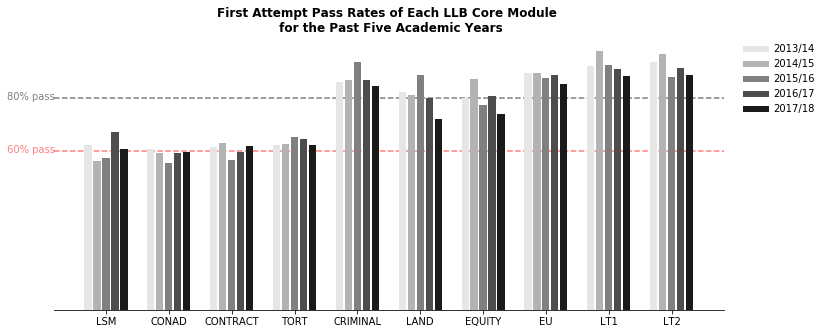

In [20]:
# Make a graph that shows how pass rates vary by module and year

# Make a dropdown menu to control whether 
# 1) first attempt, second attempt or third attempt,
# 2) type of attempt (initial, reassessment, retake, dr, fr)
# 3) pass rate, submission rate
# 4) for different assignments?
# 5) all students or only PT, FT, 6YR, only those who failed, failed different assignments?

# Start by making a table that shows pass rates by module, then by year
graph1_df = pd.DataFrame()
for dfname, df in module_summary.items():
    tmp_df = df.loc['% Pass (after reassessment same year)', :].to_frame()
    tmp_index = np.array([dfname] * len(tmp_df))
    tmp_df.set_index(tmp_index, append=True, inplace=True)
    tmp_df = tmp_df.swaplevel()
    graph1_df = pd.concat([graph1_df, tmp_df])  

# Format inputs for graphing
colors_dict = {'201314': '0.9', '201415': '0.7', '201516': '0.5', '201617': '0.3', '201718':'0.1'}
graph_colors=[colors_dict[i] for i in graph1_df.index.get_level_values(1)]
values = graph1_df['% Pass (after reassessment same year)'].values.tolist()
names_tuples = graph1_df.index.values.tolist()
names = [str1 + ' ' + str2 for (str1, str2) in names_tuples]
x_pos = [1,2,3,4,5, 8,9,10,11,12, 15,16,17,18,19, 22,23,24,25,26,
         29,30,31,32,33, 36,37,38,39,40, 43,44,45,46,47,
         50,51,52,53,54, 57,58,59,60,61, 64,65,66,67,68]
names_pos = [3, 10, 17, 24, 31, 38, 45, 52, 59, 66]

# Make and format graph
plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.axhline(y=80, color='k', linestyle='--', alpha=0.5, zorder=0)
plt.axhline(y=60, color='r', linestyle='--', alpha=0.5, zorder=0)
ax.bar(x_pos, values, color=graph_colors)   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tick_params(axis='y',left=False,labelleft=False)
plt.xticks(names_pos, module_names, fontsize=10)
plt.text(-8, 79, '80% pass', alpha=0.5)
plt.text(-8, 59, '60% pass', color='r', alpha=0.5)
custom_lines = [Line2D([0], [0], color='0.9', lw=6),
                Line2D([0], [0], color='0.7', lw=6),
                Line2D([0], [0], color='0.5', lw=6),
                Line2D([0], [0], color='0.3', lw=6),
                Line2D([0], [0], color='0.1', lw=6)]
ax.legend(custom_lines, ['2013/14','2014/15', '2015/16', '2016/17', '2017/18'], loc='upper right', frameon=False, bbox_to_anchor=(1.15, 1.01))
plt.title('First Attempt Pass Rates of Each LLB Core Module \n for the Past Five Academic Years',
         fontweight='bold')
plt.show()

### Making a 'STUDENTS' dataframe storing relevant information and computed variables of each student

In [21]:
# Remove all students that appear in modules pre 2013 
# because land appeared in year 1, tort in year 2 
# for FT students prior to 2013
for dfname, df in module_files.items():
    module_files[dfname] = df[~df.index.isin(students_pre2013)]

In [22]:
STUDENTS, module_files = make_students_dataframe(module_files)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
STUDENTS.head()

In [ ]:
STUDENTS.columns

In [ ]:
STUDENTS.to_excel("/Users/Kate/Desktop/Vicky project/"
                        "Data/Python Output Data/STUDENTS.xlsx")

In [ ]:
# check that all students have been processed correctly
any(STUDENTS['Entire Record'].isnull())

In [ ]:
len(STUDENTS)

In [ ]:
STUDENTS['Year 1 Progression'].unique()

### Creating dataframes of first, second, third, and fourth attempts of each module (course) containing relevant attempt information

In [ ]:
ATTEMPTS, module_files = make_attempts_dataframe(
                          STUDENTS, module_files, n_assessments_module_dict)

In [ ]:
first_attempts = ATTEMPTS['first'].copy()
first_attempts.reset_index(inplace=True)
first_attempts.head()

In [ ]:
first_attempts.columns

In [ ]:
first_attempts.to_excel("/Users/Kate/Desktop/Vicky project/"
                        "Data/Python Output Data/FIRST ATTEMPTS.xlsx")

In [ ]:
second_attempts = ATTEMPTS['second'].copy()
second_attempts.reset_index(inplace=True)
second_attempts.head()

In [ ]:
second_attempts.to_excel("/Users/Kate/Desktop/Vicky project/"
                        "Data/Python Output Data/SECOND ATTEMPTS.xlsx")

In [ ]:
second_attempts['Attempt Type'].value_counts(normalize=True, dropna=False)

In [ ]:
FR_df = second_attempts[second_attempts['Attempt Type'] == 'FR Reassessment']
DR_df = second_attempts[second_attempts['Attempt Type'] == 'DR Reassessment']
Retake_df = second_attempts[second_attempts['Attempt Type'] == 'Retake']

def calculate_prop_pass(df): 
    return len(df[df['Module Result'] == 'P'])/ len(df)
    
# All modules, proportion passing after FR, DR or retake second attempt
print(calculate_prop_pass(FR_df), calculate_prop_pass(DR_df), calculate_prop_pass(Retake_df))

In [ ]:
# make this into a function, and calculate these numbers for first year courses specifically

In [ ]:
third_attempts = ATTEMPTS['third'].copy()
third_attempts.reset_index(inplace=True)
third_attempts.head()

In [ ]:
third_attempts.to_excel("/Users/Kate/Desktop/Vicky project/"
                        "Data/Python Output Data/THIRD ATTEMPTS.xlsx")

In [ ]:
fourth_attempts = ATTEMPTS['fourth'].copy()
fourth_attempts.reset_index(inplace=True)
fourth_attempts.head()

In [ ]:
fourth_attempts.to_excel("/Users/Kate/Desktop/Vicky project/"
                        "Data/Python Output Data/FOURTH ATTEMPTS.xlsx")

In [ ]:
any(ATTEMPTS['fifth'].index)

# Analysis and Visualization

### Assessing the problem: what is the distribution of outcomes of LLB students?

In [ ]:
outcomes = ['Graduated','Failed out','Left in good standing',
                         'Still in program']
outcomes_ser = create_outcomes_series(STUDENTS, '2013')
x = outcomes_ser
labels = pd.Index(outcomes)
colors = ['0.75', 'r', '0.5', '0.4']
textprops = {}
fig = plt.figure(figsize=(5,5))
plt.pie(x, explode=None, labels=labels, colors=colors, autopct='%1.f%%', 
        pctdistance=0.6, shadow=False, labeldistance=1.1, startangle=15, 
        radius=1, counterclock=True, center=(0, 0), textprops=dict(fontsize=12))
plt.title('2013 Cohort',
         fontsize=14, fontweight='bold');

### What does the progression of LLB students look like?

In [ ]:
year_entered = '201314'
# removing students who entered at year 2
STUDENTS_copy = STUDENTS.copy()
STUDENTS_copy = STUDENTS_copy[STUDENTS_copy['Year 1 Progression'] == 'Year 1']
# plotting figure with function in custom scripts
plot_single_cohort_progression(STUDENTS_copy, year_entered)

### When do students 'get stuck'?

In [ ]:
# What proportion of students who are progressing on time graduate?
STUDENTS.loc[(STUDENTS['Year started'] == '201314') & 
        STUDENTS['Year 3 Progression'].isin(['Year 3']), 
            'Current status'].value_counts(normalize=True)

In [ ]:
years_of_interest = ['201314','201415','201516','201617']
plot_all_yrs_progression(STUDENTS_copy, years_of_interest)

In [ ]:
# Distribution of years students are working on when they fail out
left_badly = ['Terminated', 'Withdrawn', 'Left after failing',
                  'Left prematurely - details unknown']
(STUDENTS.loc[STUDENTS['Current status'].isin(left_badly), 
             'Final progression status'].value_counts(normalize=True))

### Why are students failing year 1 courses? 

### What proportion of failures in year 1 are due to non-submission?


In [ ]:
get_prop_failures_yr_1_due_to_NS(first_attempts)

### What is the probability of passing first year module if submit all assignments?

In [ ]:
get_prob_pass_FYC_if_submit(first_attempts)

In [24]:
!git --version

xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun
